## Skin Cancer Classification Transfer Learning InceptionResNetV2

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn

### Creating Dataset

In [6]:
os.mkdir("HAM_Dataset")
base = "HAM_Dataset"

os.mkdir(os.path.join(base, "MEL"))
os.mkdir(os.path.join(base, "NV"))
os.mkdir(os.path.join(base, "BCC"))
os.mkdir(os.path.join(base, "AKIEC"))
os.mkdir(os.path.join(base, "BKL"))
os.mkdir(os.path.join(base, "DF"))
os.mkdir(os.path.join(base, "VASC"))

print(os.listdir(base))

['DF', 'VASC', 'BKL', 'AKIEC', 'BCC', 'NV', 'MEL']


In [7]:
for image in os.listdir('ISIC2018_Task3_Training_Input'):
    if "jpg" not in image:
        os.remove('ISIC2018_Task3_Training_Input/'+image)

for image in os.listdir('ISIC2018_Task3_Training_Input'):
    if "jpg" not in image:
        print(image)

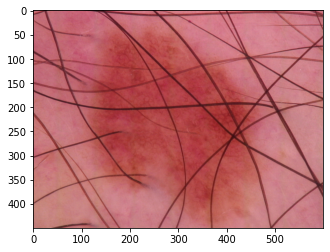

(450, 600, 3)


In [8]:
img = os.listdir('ISIC2018_Task3_Training_Input')[0]
skin=cv2.imread('ISIC2018_Task3_Training_Input/'+img)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.show()

print(skin.shape)

In [9]:
mapping = {0:"MEL", 1:"NV", 2:"BCC", 3:"AKIEC", 4:"BKL", 5:"DF", 6:"VASC"}

df_labels = pd.read_csv("../input/isictruth/ISIC2018GroundTruth.csv")
for i in range(len(df_labels)):
    labels = df_labels.iloc[i,1:]
    df_labels.loc[i,"label"] = mapping[list(labels).index(1)]

#df_labels["label"]=df_labels["label"].astype(int)
df_labels.set_index('image', inplace=True)

df_labels.head()

,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label
image,,,,,,,,
ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


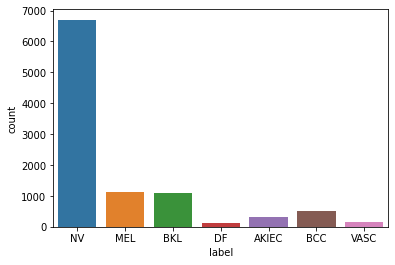

In [10]:
sns.countplot(x=df_labels["label"])
plt.show()

In [11]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'],
                                                  y=df_labels["label"])
class_wt_dict=dict(enumerate(class_weights))
class_wt_dict

{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

In [12]:
from tqdm import tqdm

images = os.listdir('ISIC2018_Task3_Training_Input')

for image in tqdm(images):
    fname=image[:-4]
    label=df_labels.loc[fname, "label"]
    src = os.path.join('ISIC2018_Task3_Training_Input', image)
    dst = os.path.join('HAM_Dataset', label, image)
    shutil.copyfile(src, dst)

100%|██████████| 10015/10015 [00:05<00:00, 1784.59it/s]


### Train Test Split

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input as base_preprocess


image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               # rescale=1/255,
                               validation_split=0.15)

data_dir = 'HAM_Dataset'
batch_size = 64
target_size = (224,224)
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


<AxesSubplot:ylabel='count'>

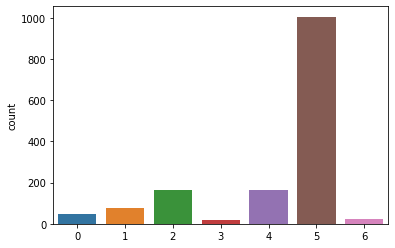

In [15]:
sns.countplot(x=test_image_gen.classes)

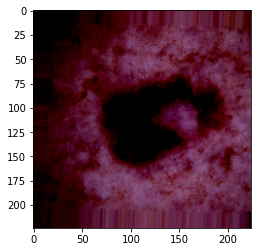

In [16]:
plt.imshow(train_image_gen[0][0][0])

## Transfer Learning using InceptionResNetV2 Model

In [1]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_203[0][0]    
___________________________________________________________________________________________

In [19]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

### Model Training

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_dn121.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [26]:
history = tl_model.fit(train_image_gen,
                       epochs=15, 
                       validation_data = test_image_gen,
                       class_weight=class_wt_dict,
                       callbacks=callback_list)

Epoch 1/15
134/134 [==============================] - 237s 2s/step - loss: 0.6530 - accuracy: 0.9643 - val_loss: 1.0932 - val_accuracy: 0.8773

Epoch 00001: val_accuracy did not improve from 0.88326
Epoch 2/15
134/134 [==============================] - 236s 2s/step - loss: 0.6368 - accuracy: 0.9703 - val_loss: 1.0611 - val_accuracy: 0.8766

Epoch 00002: val_accuracy did not improve from 0.88326
Epoch 3/15
134/134 [==============================] - 236s 2s/step - loss: 0.6210 - accuracy: 0.9731 - val_loss: 1.0646 - val_accuracy: 0.8859

Epoch 00003: val_accuracy improved from 0.88326 to 0.88592, saving model to best_model_dn121.hdf5
Epoch 4/15
134/134 [==============================] - 236s 2s/step - loss: 0.6203 - accuracy: 0.9685 - val_loss: 1.0202 - val_accuracy: 0.8866

Epoch 00004: val_accuracy improved from 0.88592 to 0.88659, saving model to best_model_dn121.hdf5
Epoch 5/15
134/134 [==============================] - 235s 2s/step - loss: 0.5992 - accuracy: 0.9748 - val_loss: 1.017

### Model Evaluation

In [27]:
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist3.csv')

<AxesSubplot:>

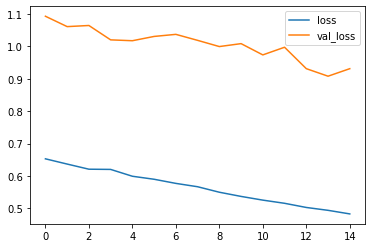

In [28]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<AxesSubplot:>

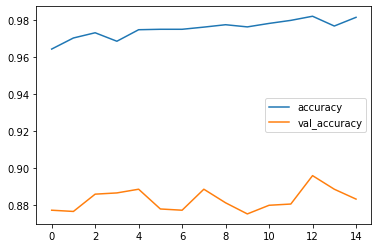

In [29]:
metrics[["accuracy","val_accuracy"]].plot()

In [30]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = test_image_gen.classes

24/24 [==============================] - 35s 1s/step


In [32]:
pred_df = pd.DataFrame({"true":test_labels, "pred":predictions})
pred_df.to_csv("pred_df.csv")

In [33]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        49
           1       0.84      0.88      0.86        77
           2       0.81      0.78      0.80       164
           3       0.88      0.82      0.85        17
           4       0.74      0.64      0.69       166
           5       0.94      0.96      0.95      1005
           6       0.79      0.90      0.84        21

    accuracy                           0.89      1499
   macro avg       0.81      0.82      0.81      1499
weighted avg       0.89      0.89      0.89      1499



Normalized confusion matrix
[[0.73469388 0.12244898 0.08163265 0.         0.04081633 0.02040816
  0.        ]
 [0.05194805 0.88311688 0.02597403 0.         0.         0.03896104
  0.        ]
 [0.02439024 0.01829268 0.7804878  0.01219512 0.06097561 0.10365854
  0.        ]
 [0.11764706 0.         0.         0.82352941 0.05882353 0.
  0.        ]
 [0.02409639 0.01204819 0.06626506 0.         0.63855422 0.23493976
  0.02409639]
 [0.0039801  0.00199005 0.0119403  0.         0.02288557 0.95820896
  0.00099502]
 [0.         0.         0.04761905 0.         0.04761905 0.
  0.9047619 ]]


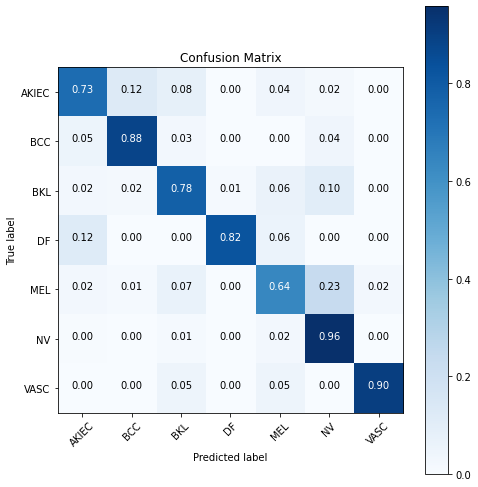

In [34]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
cm_plot_labels = list(test_image_gen.class_indices.keys())

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)